Impoting the necessary dataset

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.stats import skew, mode
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats

Reading the dataset

In [2]:
df = pd.read_csv("dirty_cafe_sales.csv")

Basic information about the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [4]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [5]:
df.describe()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_9226047,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


In [6]:
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64


The data contains multiple null values. Visualizing to find the appropriate filler for the data and Applying the Filler

Skewness before imputation:
Quantity         NaN
Price Per Unit   NaN
Total Spent      NaN
dtype: float64


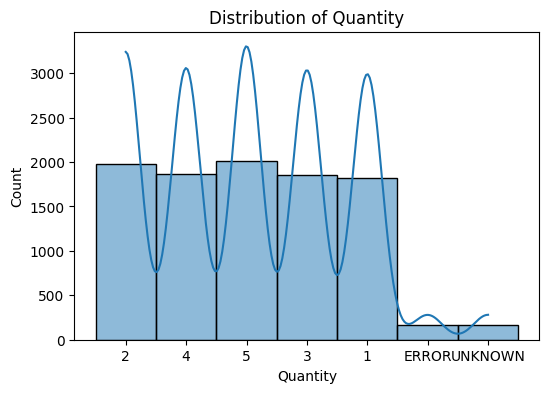

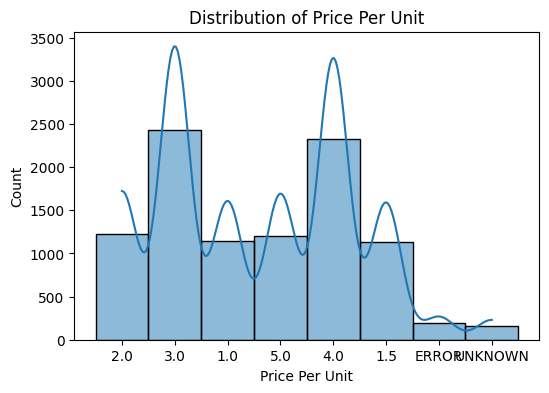

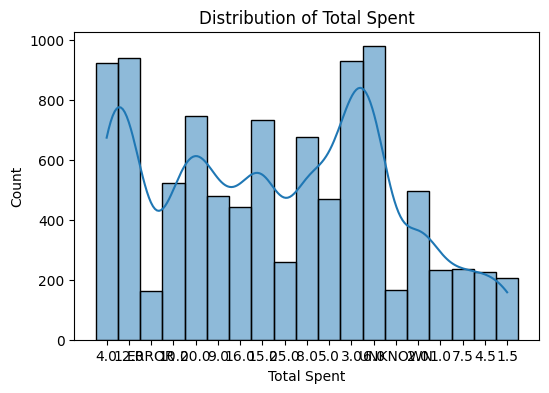

Skewness after imputation:
Quantity         -0.005339
Price Per Unit   -0.001709
Total Spent       0.867237
dtype: float64


In [7]:

print("Skewness before imputation:")
print(df[["Quantity", "Price Per Unit", "Total Spent"]].apply(skew))

for col in ["Quantity", "Price Per Unit", "Total Spent"]:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

df[["Quantity", "Price Per Unit", "Total Spent"]] = df[["Quantity", "Price Per Unit", "Total Spent"]].apply(pd.to_numeric, errors='coerce')

for col in ["Quantity", "Price Per Unit", "Total Spent"]:
    imputer = SimpleImputer(strategy='median')
    df[[col]] = imputer.fit_transform(df[[col]])

print("Skewness after imputation:")
print(df[["Quantity", "Price Per Unit", "Total Spent"]].apply(skew))

Filling the categorical columns with the mode values

In [8]:
for col in ["Item", "Payment Method", "Location", "Transaction Date"]:
    mode_value = df[col].mode()[0]  # Get most frequent value
    df[col] = df[col].fillna(mode_value)  # Fill missing values with mode

Removing duplicaates based on Transaction IDs and keeping those with last transaction date.

In [9]:

df = df.sort_values(by="Transaction Date")  
df = df.drop_duplicates(subset=["Transaction ID", "Item"], keep="last")

Identifying ig there are any suspicious transactions

In [10]:
Q1 = df["Total Spent"].quantile(0.25)
Q3 = df["Total Spent"].quantile(0.75)
IQR = Q3 - Q1

df["Anomaly"] = (df["Total Spent"] < (Q1 - 1.5 * IQR)) | (df["Total Spent"] > (Q3 + 1.5 * IQR))

print(df[df["Anomaly"]])
print("No huge analomy in transactions found")

     Transaction ID   Item  Quantity  Price Per Unit  Total Spent  \
546     TXN_6669417  Salad       5.0             5.0         25.0   
2224    TXN_2861396  Salad       5.0             5.0         25.0   
9791    TXN_1232346  Salad       5.0             5.0         25.0   
7713    TXN_1665056  Salad       5.0             5.0         25.0   
3129    TXN_5137315  Salad       3.0             5.0         25.0   
...             ...    ...       ...             ...          ...   
5911    TXN_9882485  Salad       5.0             5.0         25.0   
5153    TXN_8872160  Salad       5.0             5.0         25.0   
744     TXN_2004851  Salad       5.0             5.0         25.0   
885     TXN_8868960  Salad       5.0             5.0         25.0   
4392    TXN_8167275  Salad       5.0             5.0         25.0   

      Payment Method  Location Transaction Date  Anomaly  
546   Digital Wallet  Takeaway       2023-01-03     True  
2224     Credit Card   UNKNOWN       2023-01-04     T

Finding and replacing outliers using the winorisation technique taught.

In [11]:
num_cols = df.select_dtypes(include=['number']).columns  # Select only numerical columns

lower_percentile = 2  
upper_percentile = 98  

for col in num_cols:
    lower_bound = np.percentile(df[col], lower_percentile)
    upper_bound = np.percentile(df[col], upper_percentile)
    df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))


Standardizing dataset(replacing error with unknown)

In [12]:
def standardize_item_name(item):
    replacements = {"ERROR": "Unknown", "UNKNOWN": "Unknown", "Error": "Unknown"}
    return replacements.get(item, item.strip().title())

df["Item"] = df["Item"].apply(standardize_item_name)
df["Payment Method"] = df["Payment Method"].apply(standardize_item_name)
df["Location"] = df["Location"].apply(standardize_item_name)
df["Payment Method"] = df["Payment Method"].str.title().str.strip()
df["Location"] = df["Location"].str.title().str.strip()

df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors='coerce')

Optional(Replace the 'unknown' values with mode for that column)

In [13]:
cat_cols = ["Item", "Payment Method", "Location"]  # List of categorical columns to process

for col in cat_cols:
    mode_value = df[df[col] != "Unknown"][col].mode()[0]  # Find the most frequent (mode) value, excluding "Unknown"
    df[col] = df[col].replace("Unknown", mode_value)  # Replace "Unknown" with mode

Exploratory Data Analysis and Visualization(Univariate, Bivariate and Multivariate)

In [14]:
df.describe()

,Quantity,Price Per Unit,Total Spent,Transaction Date
count,10000.000000,10000.00000,10000.00000,9540
mean,3.027100,2.95265,8.87795,2023-07-01 23:00:31.698113024
min,1.000000,1.00000,1.00000,2023-01-01 00:00:00
25%,2.000000,2.00000,4.00000,2023-04-01 00:00:00
50%,3.000000,3.00000,8.00000,2023-07-02 00:00:00
75%,4.000000,4.00000,12.00000,2023-10-02 00:00:00
max,5.000000,5.00000,25.00000,2023-12-31 00:00:00
std,1.384614,1.24396,5.86059,NaN


Skewness in the dataset

In [15]:
print("Skewness:")
print(df[num_cols].apply(skew))
print("Mode:")
print(df[num_cols].apply(lambda x: mode(x)[0]))

Skewness:
Quantity         -0.005339
Price Per Unit   -0.001709
Total Spent       0.867237
dtype: float64
Mode:
Quantity          3.0
Price Per Unit    3.0
Total Spent       8.0
dtype: float64


Item purchase frequency distribution, total spent distribution


Frequency Distribution for Item:
Item
Juice       2140
Coffee      1165
Salad       1148
Cake        1139
Sandwich    1131
Smoothie    1096
Cookie      1092
Tea         1089
Name: count, dtype: int64


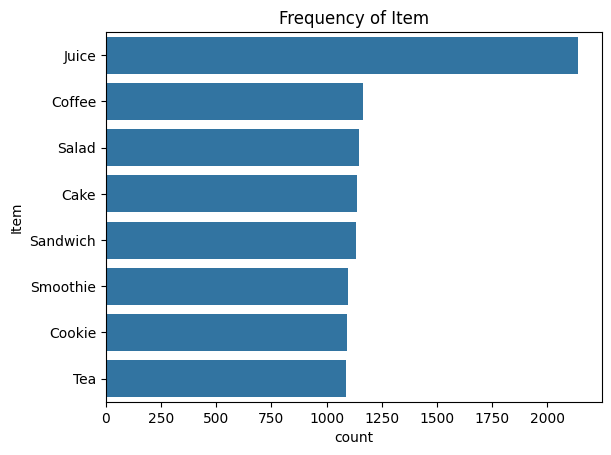


Frequency Distribution for Payment Method:
Payment Method
Digital Wallet    5469
Credit Card       2273
Cash              2258
Name: count, dtype: int64


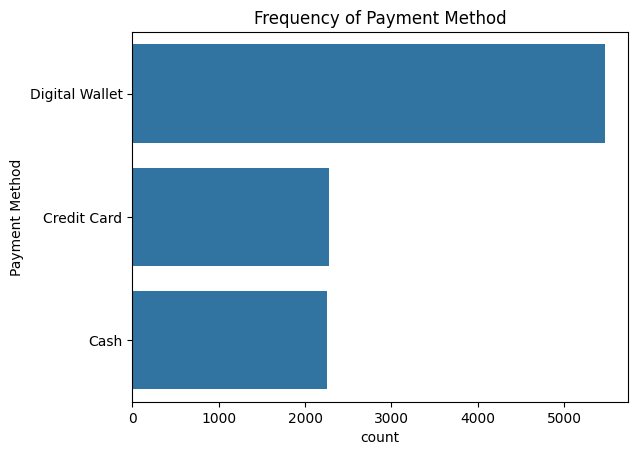


Frequency Distribution for Location:
Location
Takeaway    6983
In-Store    3017
Name: count, dtype: int64


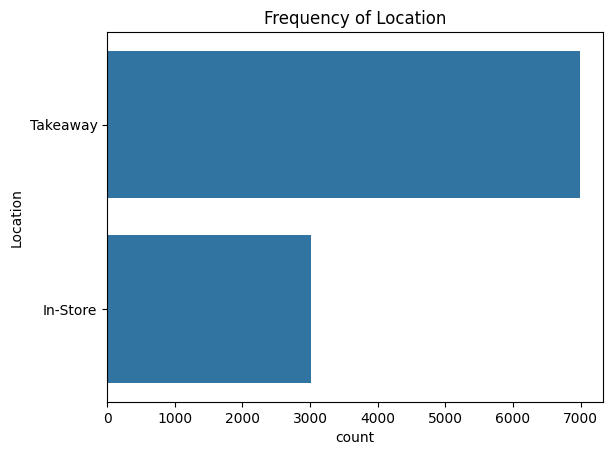

In [16]:

for col in ["Item", "Payment Method", "Location"]:
    print(f"\nFrequency Distribution for {col}:")
    print(df[col].value_counts())
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f"Frequency of {col}")
    plt.show()

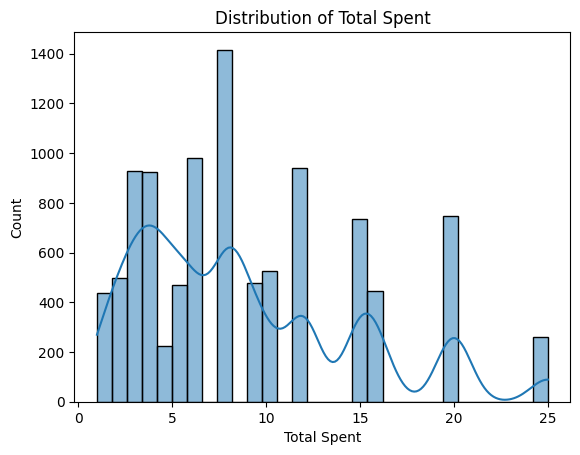

In [17]:
sns.histplot(df["Total Spent"], bins=30, kde=True)
plt.title("Distribution of Total Spent")
plt.show()

Box Plot for total spent

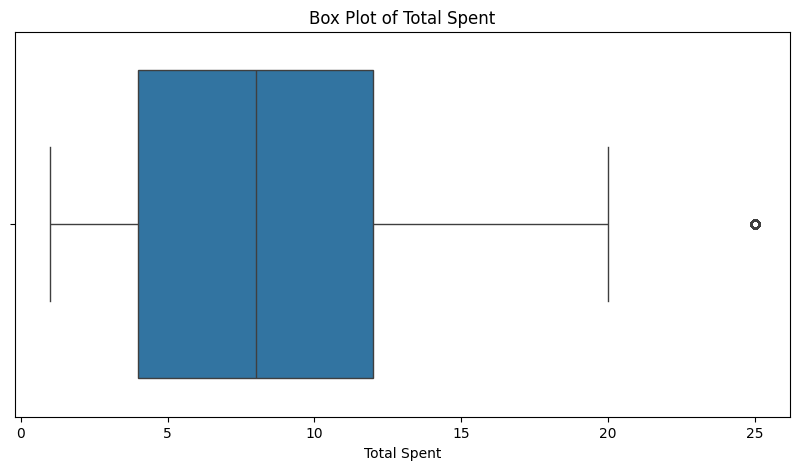

In [18]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["Total Spent"])
plt.title("Box Plot of Total Spent")
plt.show()

Correlation between numerical columns

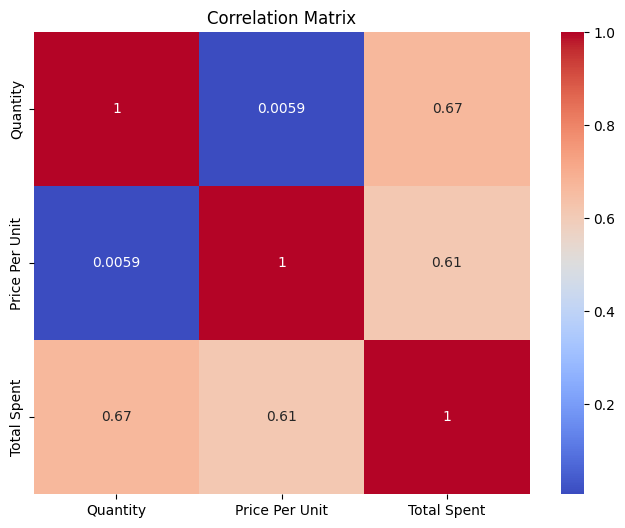

In [19]:
plt.figure(figsize=(8, 6))
num_cols = df.select_dtypes(include=['number']).columns  # Select only numerical columns
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")

plt.title("Correlation Matrix")
plt.show()

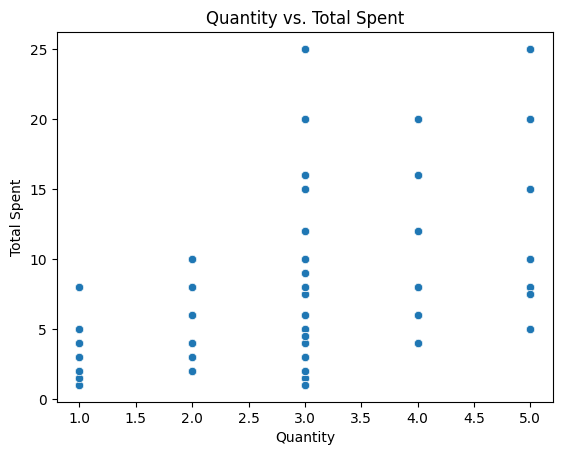

In [20]:
sns.scatterplot(x=df["Quantity"], y=df["Total Spent"])
plt.title("Quantity vs. Total Spent")
plt.show()

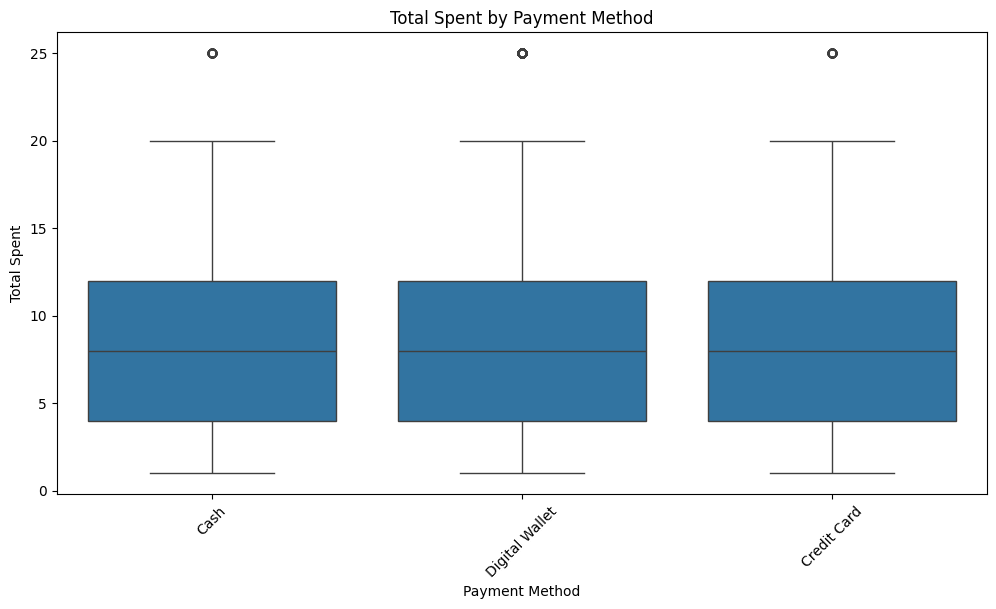

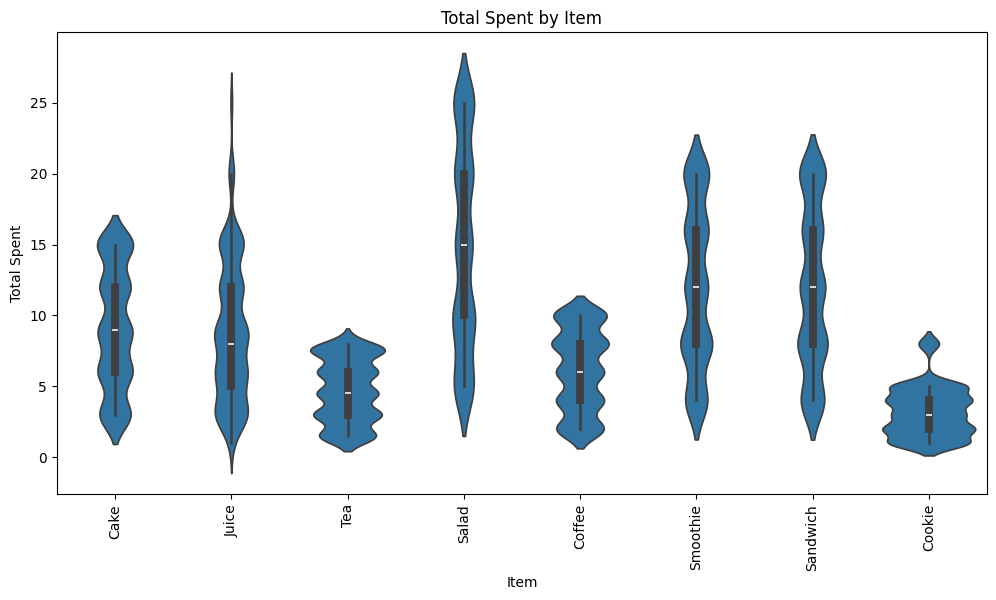

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["Payment Method"], y=df["Total Spent"])
plt.xticks(rotation=45)
plt.title("Total Spent by Payment Method")
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(x=df["Item"], y=df["Total Spent"])
plt.xticks(rotation=90)
plt.title("Total Spent by Item")
plt.show()

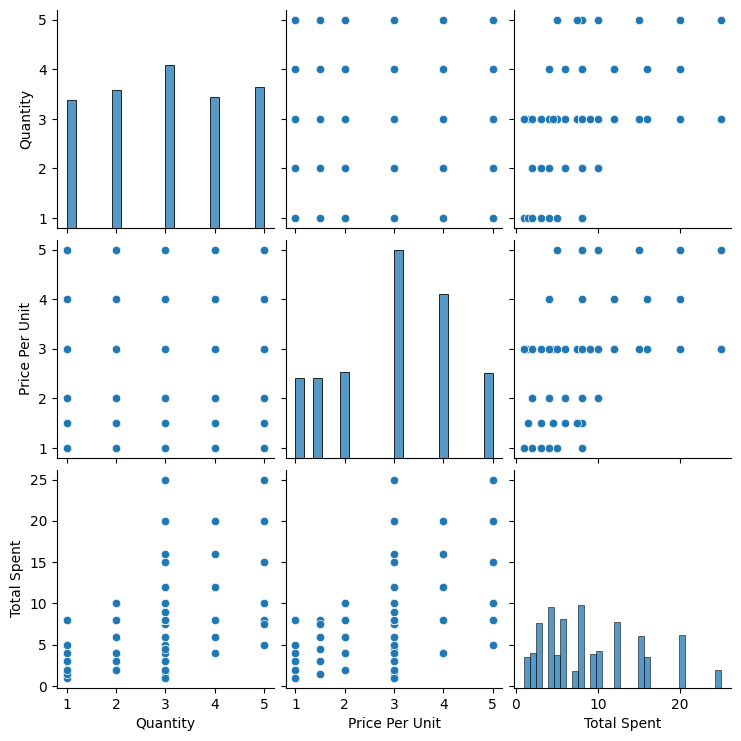

In [22]:
sns.pairplot(df[["Quantity", "Price Per Unit", "Total Spent"]])
plt.show()

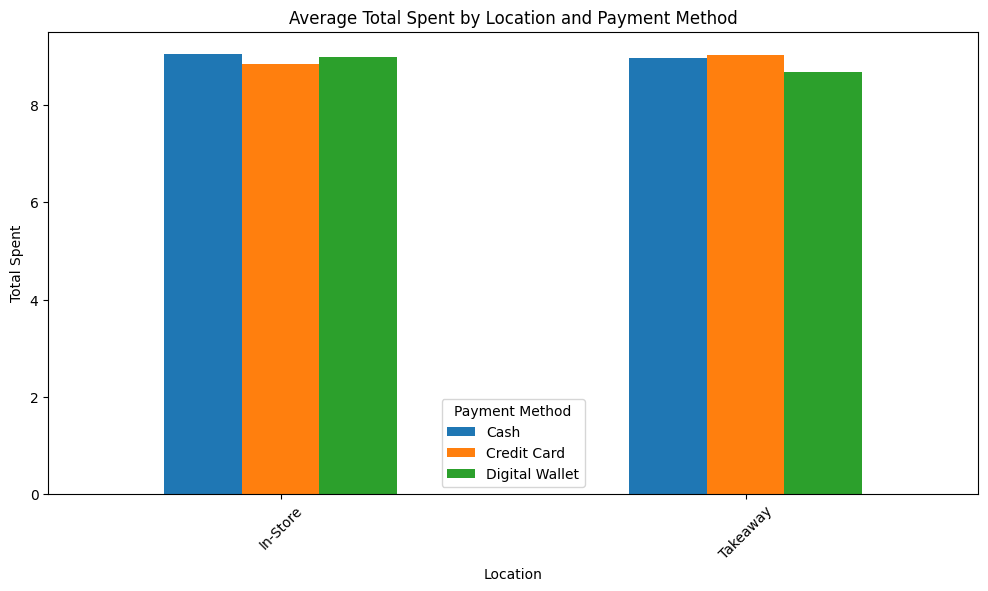

In [23]:
# Grouped comparisons
grouped_data = df.groupby(["Location", "Payment Method"])["Total Spent"].mean().unstack()
grouped_data.plot(kind="bar", figsize=(12, 6))
plt.title("Average Total Spent by Location and Payment Method")
plt.ylabel("Total Spent")
plt.xticks(rotation=45)
plt.legend(title="Payment Method")
plt.show()

mode of payment is not affecting payment methodology much

Time Trend Analysis

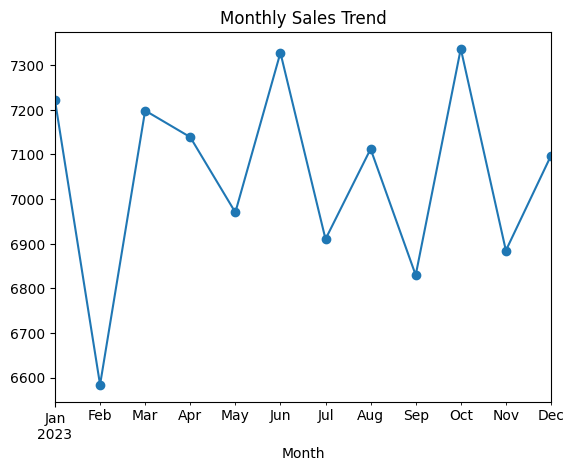

In [24]:
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])
df["Month"] = df["Transaction Date"].dt.to_period("M")

monthly_sales = df.groupby("Month")["Total Spent"].sum()
monthly_sales.plot(kind="line", title="Monthly Sales Trend", marker="o")
plt.show()


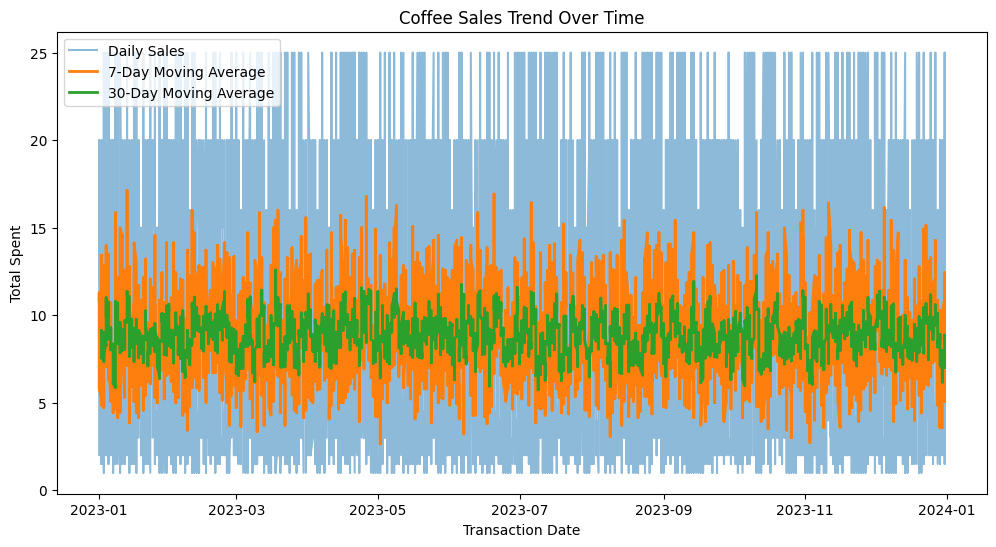

In [25]:
df.sort_values("Transaction Date", inplace=True)
df["Total Spent"] = pd.to_numeric(df["Total Spent"], errors='coerce')  
df.dropna(subset=["Total Spent"], inplace=True) 
df = df[df["Total Spent"].replace([np.inf, -np.inf], np.nan).notna()] 

df["7-day MA"] = df["Total Spent"].rolling(window=7).mean()
df["30-day MA"] = df["Total Spent"].rolling(window=30).mean()

plt.figure(figsize=(12,6))
plt.plot(df["Transaction Date"], df["Total Spent"], label="Daily Sales", alpha=0.5)
plt.plot(df["Transaction Date"], df["7-day MA"], label="7-Day Moving Average", linewidth=2)
plt.plot(df["Transaction Date"], df["30-day MA"], label="30-Day Moving Average", linewidth=2)
plt.title("Coffee Sales Trend Over Time")
plt.xlabel("Transaction Date")
plt.ylabel("Total Spent")
plt.legend()
plt.show()


Top 5 Peak Sales Days:
Transaction Date
2023-07-24    381.5
2023-11-07    369.0
2023-01-05    363.5
2023-06-16    362.5
2023-06-06    355.5
Name: Total Spent, dtype: float64


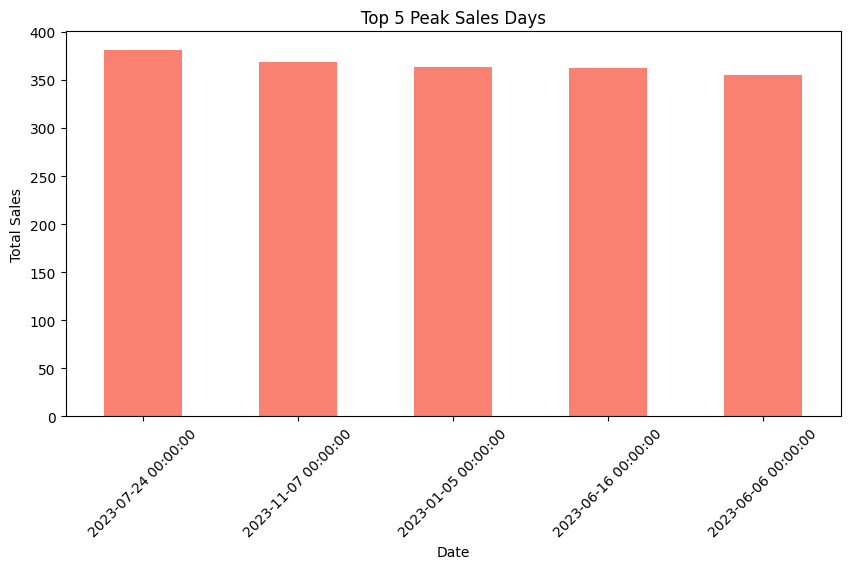

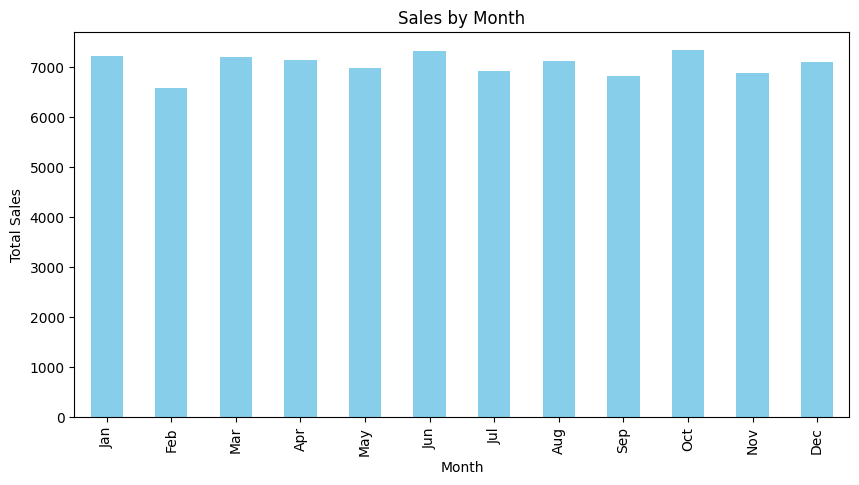

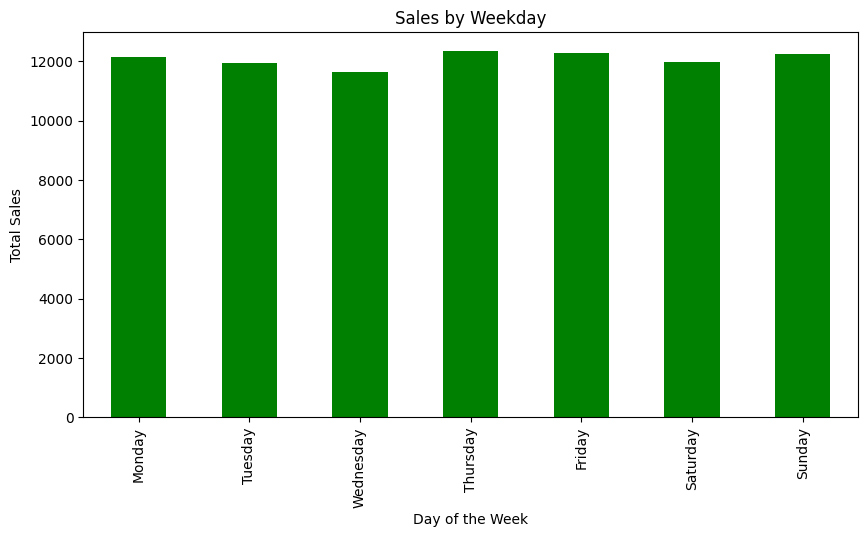

In [26]:
df["Year"] = df["Transaction Date"].dt.year
df["Month"] = df["Transaction Date"].dt.month
df["Day"] = df["Transaction Date"].dt.day
df["Weekday"] = df["Transaction Date"].dt.day_name()  # Get weekday names

# 1. Identifying Peak Days
top_days = df.groupby("Transaction Date")["Total Spent"].sum().nlargest(5)  # Top 5 days
print("Top 5 Peak Sales Days:")
print(top_days)

plt.figure(figsize=(10,5))
top_days.plot(kind='bar', color='salmon')
plt.title("Top 5 Peak Sales Days")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()

monthly_sales = df.groupby("Month")["Total Spent"].sum()

plt.figure(figsize=(10,5))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title("Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()
weekday_sales = df.groupby("Weekday")["Total Spent"].sum()
weekday_sales = weekday_sales.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])  # Ensure order

plt.figure(figsize=(10,5))
weekday_sales.plot(kind='bar', color='green')
plt.title("Sales by Weekday")
plt.xlabel("Day of the Week")
plt.ylabel("Total Sales")
plt.show()

ANOVA analysis

In [ ]:
# ANOVA Analysis: Comparing Total Spent across different Payment Methods
df_payment = df[df['Payment Method'].notna()]
payment_groups = [df_payment[df_payment["Payment Method"] == method]["Total Spent"].dropna()
                  for method in df_payment["Payment Method"].unique()]

anova_stat, anova_p = stats.f_oneway(*payment_groups)
print(f"ANOVA Analysis:\nF-statistic: {anova_stat:.4f}, p-value: {anova_p:.4f}\n")


ANOVA Analysis:
F-statistic: 1.6165, p-value: 0.1986

T-test Result: TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))


C:\Users\Dinesh\AppData\Local\Temp\ipykernel_20776\6535706.py:11: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_test_result = stats.ttest_ind(


Saving the cleaned dataset

In [27]:
df.to_csv("cleaned_cafe_sales.csv", index=False)